# Estudo de Caso

Reconhecimento de imagens médicas

1. Importando as bibliotecas:

In [2]:
import numpy as np
import pandas as pd

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

ModuleNotFoundError: No module named 'tensorflow'

In [6]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

ModuleNotFoundError: No module named 'sklearn'

2. Definindo as propriedades das imagens:

In [6]:
# Parâmtros de largura, altura, dimensões e quantidade de canais
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

3. Preparando o conjunto de dados para o modelo de treinamento:

In [8]:
filenames=os.listdir('C:\\Users\\Spock\\Downloads\\IA\\parte2\\raio-x-torax\\treino')


# Após realizar o download e descompactar a pasta raio-x-torax.zip, localize o caminho correto do local
# da pasta. Você precisará acessar a pasta treino. Note que a cada pasta, é necessário o uso de barras
# duplas invertivas.

In [9]:
# Criando as categorias para o modelo
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='pneumonia':
        categories.append(1) # estabelecendo pneumonia como categoria 1
    else:
        categories.append(0) # estabelecendo normal como categoria 0

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

df.head(80)

,filename,category
0,normal.0.jpg,0
1,normal.1.jpg,0
2,normal.10.jpg,0
3,normal.11.jpg,0
4,normal.12.jpg,0
...,...,...
75,normal.77.jpg,0
76,normal.78.jpg,0
77,normal.79.jpg,0
78,normal.8.jpeg,0


<AxesSubplot:>

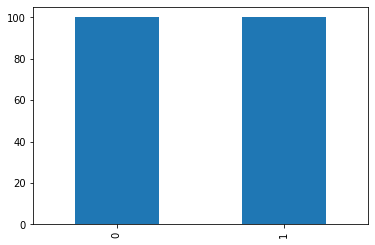

In [10]:
# Verificando a quantidade de imagens em cada categoria
df['category'].value_counts().plot.bar()

4. Criando o modelo da rede neural:

In [11]:
# Implementando o modelo sequencial e suas camadas de rede neural
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

5. Analisando o modelo:

In [12]:
# Visualizando o modelo sequencial e suas camadas
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

6. Definindo as chamadas de retorno e taxa de aprendizado:
* chamada de retorno é um conjunto de funções a serem aplicadas em uma determinada etapa do procedimento do treinamento. Isso incluirá interromper o treinamento quando atingir uma certa pontuação de precisão/perda, para salvar o modelo após cada época bem-sucedida e ajustar as taxas de aprendizado 
    * Early Stop: Para evitar overfitting, interromperemos o aprendizado após 10 épocas e o valor val_loss não diminuirá.
    * Redução da taxa de aprendizado: Reduziremos a taxa de aprendizado quando a precisão não aumentar em 2 etapas.

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

7. Gerenciando os dados:

In [14]:
df["category"] = df["category"].replace({0:'normal', 1:'pneumonia'})
train_df,validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

8. Gerando dados de treinamento e validação:

In [16]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                  )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    "C:\\Users\\Marcelo Viana\\Documents\\Projetos_Jupyter\\raio-x-torax\\treino",
# note que o caminho para a pasta treino deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=Image_Size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:\\Users\\Marcelo Viana\\Documents\\Projetos_Jupyter\\raio-x-torax\\treino", 
# note que o caminho para a pasta treino deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)


Found 160 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


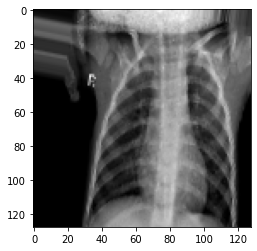

In [17]:
# Visualizando as imagens dentro do modelo
x , y  = train_generator.next()
for i in range(0,1):
    random_image = x[i]
    plt.imshow(random_image)
    plt.show()

9. Treinamento do modelo:

In [18]:
epochs=10 # quantidade de épocas de treinamento. É possível aumentar ou dimunir a quantidade.
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
10/10 [==============================] - 16s 1s/step - loss: 1.1713 - accuracy: 0.7655 - val_loss: 1.5155 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 0.7663 - accuracy: 0.7931 - val_loss: 4.2346 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 10s 1s/step - loss: 0.6635 - accuracy: 0.8069 - val_loss: 6.3094 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 0.7537 - accuracy: 0.7310 - val_loss: 7.3784 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 12s 1s/step - loss: 0.5858 - accuracy: 0.8067 - val_loss: 7.5899 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 0.5122 - accuracy: 0.8207 - val_loss: 9.5134 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 12s 1s/step - loss: 0.6635 - a

10. Salvando o modelo:

In [19]:
model.save("modelo_raio-x-torax_10epoch.h5") # documento gerado com a base de treinamento.

11. Preparando os dados de teste:

In [20]:
test_filenames = os.listdir("C:\\Users\\Marcelo Viana\\Documents\\Projetos_Jupyter\\raio-x-torax\\teste")
# note que o caminho para a pasta teste deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.

test_df = pd.DataFrame({
    'filename': test_filenames
})

12. Testando os dados de treinamento:

In [21]:
test_generator = train_datagen.flow_from_dataframe(test_df,
                                                   'C:\\Users\\Marcelo Viana\\Documents\\Projetos_Jupyter\\raio-x-torax\\teste',
# note que o caminho agora é para a pasta TESTE. Atente-se para não apagar as aspas e barras duplas.
                                                   x_col='filename',
                                                   y_col=None,
                                                   target_size=Image_Size,
                                                   class_mode=None,
                                                   batch_size=batch_size
                                                   )

nb_samples = test_df.shape[0]

Found 101 validated image filenames.


13. Fazendo as previsões das categorias:

In [22]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

7/7 [==============================] - 4s 665ms/step


14. Convertendo os labels em categorias:

In [23]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'pneumonia': 1, 'normal': 0 })

15. Visualizando os resultados da previsão:

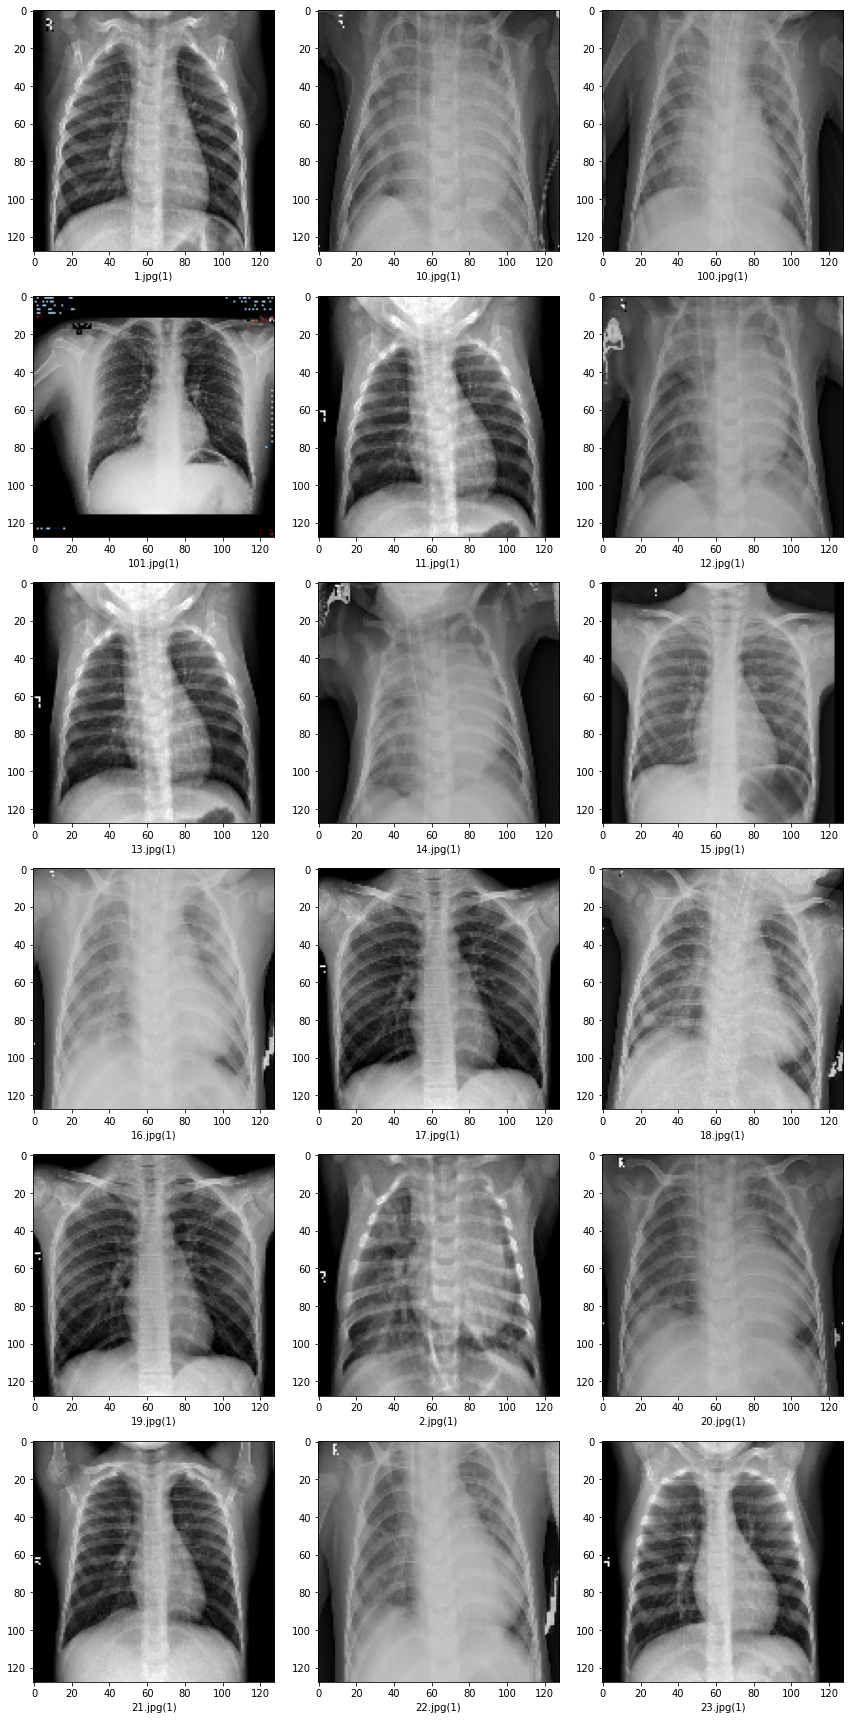

In [24]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:\\Users\\Marcelo Viana\\Documents\\Projetos_Jupyter\\raio-x-torax\\teste\\"+filename, target_size=Image_Size)
# note que o caminho para a pasta TESTE deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [21]:
# Instalação opcional da biblioteca, execute apenas se o passo 16 apresentar problema.
pip install anaconda

Note: you may need to restart the kernel to use updated packages.


In [28]:
# Instale a biblioteca do OpenCV para o tratamento de imagens.
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


16. Testando o desempenho do modelo em dados personalizados:

1/1 [==============================] - 0s 190ms/step
[0.7977153 0.2022847]
Diagnóstico indicado: RX normal


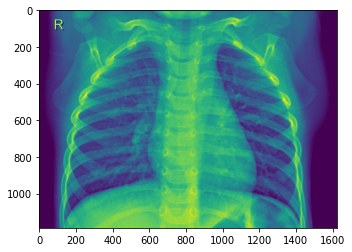

In [30]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2

im=Image.open("C:\\Users\\Marcelo Viana\\Documents\\Projetos_Jupyter\\raio-x-torax\\teste\\1.jpg")
# note que o caminho para a pasta TESTE deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
# escolha uma imagem para testar se é um raio x normal ou com pneumonia
img=im
im=im.resize(Image_Size)
im=(np.random.standard_normal([128,128,3])*255)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict([im])[0]

print(pred)

if pred[0] > pred[1]:
    print ('Diagnóstico indicado: RX normal')
else:
    print('Diagnóstico indicado: RX pneumonia')

plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 46ms/step
[0.71303606 0.28696394]
Diagnóstico indicado: RX normal


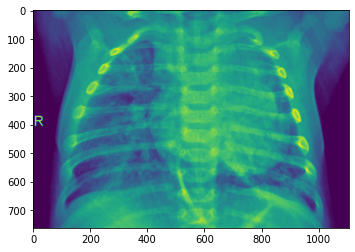

In [31]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2

im=Image.open("C:\\Users\\Marcelo Viana\\Documents\\Projetos_Jupyter\\raio-x-torax\\teste\\2.jpg")
img=im
im=im.resize(Image_Size)
im=(np.random.standard_normal([128,128,3])*255)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict([im])[0]

print(pred)

if pred[0] > pred[1]:
    print ('Diagnóstico indicado: RX normal')
else:
    print('Diagnóstico indicado: RX pneumonia')

plt.imshow(img)
plt.show()

# Classificador GUI para imagens médicas

1. Intalando o Tkinter Python:

In [32]:
pip install tk

Note: you may need to restart the kernel to use updated packages.


In [33]:
import tkinter
tkinter.TkVersion

8.6

2. Gerando a GUI:

In [34]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
import os

from keras.models import load_model
model = load_model('modelo_raio-x-torax_10epoch.h5') # arquivo do modelo treinado

# Inicializando a GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Classificação para raio-x de tórax')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = (np.random.standard_normal([128,128,3])*255)
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    image = image/255
    pred = model.predict([image])[0]
    basename = os.path.basename(file_path)
    name = int(basename.rsplit('.', 1)[0]) 
    if name % 2:
         sign = 'Diagnóstico indicado: RX normal,'
    else:
         sign = 'Diagnóstico indicado: RX pneumonia,'
    print(sign)
    label.configure(foreground='#011638', text=f'{sign} {str(max(pred*100))} {str("%")}') 

def show_classify_button(file_path):
    classify_b=Button(top,text="Classificar imagem",
   command=lambda: classify(file_path),
   padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',
font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),
    (top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    
    except:
        pass
upload=Button(top,text="Upload da imagem",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Classificação para raio-x de tórax",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

1/1 [==============================] - 0s 105ms/step
Diagnóstico indicado: RX normal,
1/1 [==============================] - 0s 45ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Anaconda\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\MARCEL~1\AppData\Local\Temp/ipykernel_28108/2933297680.py", line 37, in <lambda>
    command=lambda: classify(file_path),
  File "C:\Users\MARCEL~1\AppData\Local\Temp/ipykernel_28108/2933297680.py", line 27, in classify
    name = int(basename.rsplit('.', 1)[0])
ValueError: invalid literal for int() with base 10: 'analise'


1/1 [==============================] - 0s 24ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Anaconda\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\MARCEL~1\AppData\Local\Temp/ipykernel_28108/2933297680.py", line 37, in <lambda>
    command=lambda: classify(file_path),
  File "C:\Users\MARCEL~1\AppData\Local\Temp/ipykernel_28108/2933297680.py", line 27, in classify
    name = int(basename.rsplit('.', 1)[0])
ValueError: invalid literal for int() with base 10: 'analise'


1/1 [==============================] - 0s 53ms/step
Diagnóstico indicado: RX pneumonia,
